# Detecting and measuring objects

Once you have a masks of an image, you have two steps remaining for a classical analysis workflow. First, you need to actually find objects in your image. At the moment for example all nuclei in our mask have the same value, so we can't distinguish them. The goal is therefore to assign to the pixels of each object (nucleus) a different value: this is called connected component analysis or labeling. Second, once we have these labels, we can finally measure our objects. ```scikit-image``` offers a hand way to do that with a simple function. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from microfilm.microplot import microshow
import skimage
import skimage.io
import skimage.morphology
import scipy.ndimage as ndi

## Recreate a mask

As a first step, we import again our cells image and create a mask of the nuclei. This just recapitulates what we did in previous chapters:

In [3]:
image_stack = skimage.io.imread('../data/cellatlas/19838_1252_F8_1.tiff')

image_nuclei = image_stack[:,:,2]#blue channel in RGB
image_signal = image_stack[:,:,1]#green channel in RGB

# filter image
image_nuclei = skimage.filters.median(image_nuclei, skimage.morphology.disk(5))

# create mask and clean-up
mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
mask_nuclei = skimage.morphology.binary_closing(mask_nuclei, footprint=skimage.morphology.disk(5))
mask_nuclei = ndi.binary_fill_holes(mask_nuclei, skimage.morphology.disk(5))

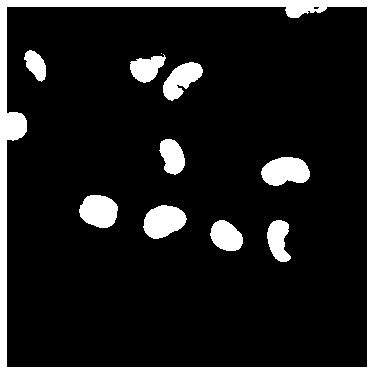

In [4]:
microshow(mask_nuclei, fig_scaling=5);

## Labelling

In order to measure objects in the image separately, we first need to label them individually. For that we can just use the ```skimage.morphology.label()``` function which looks for independent groups of white pixels and assigns them integer numbers. Note that you have the choice of considering that pixels have 4 or 8:

In [6]:
my_labels = skimage.morphology.label(mask_nuclei)

The label map shows that numbers are assigned from top to bottom in the image:

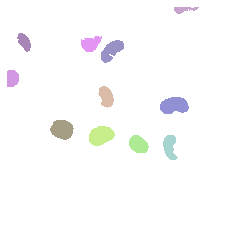

In [7]:
microshow(my_labels, cmaps='segmentation');

## Region properties

Now that we have each region labeled with a different number we can use the ```skimage.measure.regionprops_table()``` function, which takes such as label map and analyzes the geometric properties of each region. We have to specify which ```properties``` we want to use. For example the ```area``` and ```labels```:

In [8]:
my_regions = skimage.measure.regionprops_table(my_labels, properties=('label','area'))

The output is a dictionary of all properties that we asked to get out:

In [9]:
my_regions

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'area': array([ 9304., 14388.,    52., 20816., 28309., 16148., 21329., 34818.,
        32314., 34576., 22307., 24143.])}

We have briefly seen dictionaries in the introduction. To recap: they are tables with pairs of key-words and contents, and we can query contents by key-word. For example to get the list of areas, we ask:

In [10]:
my_regions['area']

array([ 9304., 14388.,    52., 20816., 28309., 16148., 21329., 34818.,
       32314., 34576., 22307., 24143.])

## Recovering image intensity information

In what we did above, we only recovered information about our mask. However often we want to obtain information on pixel values of the **original** image. For example, "what is the average intensity of each nucleus?"

Luckily ```regionprops_table``` allows us to pass as additional argument ```intensity_image``` the image we want to use to quantify intensity. Then we can for example add as property to extract the ```mean_intensity```:

In [11]:
my_regions = skimage.measure.regionprops_table(
    my_labels,intensity_image=image_signal, properties=('label','area','mean_intensity'))

Now we have access to additional parameters. For example the mean_intensity in each nucleus:

In [12]:
my_regions

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'area': array([ 9304., 14388.,    52., 20816., 28309., 16148., 21329., 34818.,
        32314., 34576., 22307., 24143.]),
 'mean_intensity': array([24.8133061 , 39.03287462, 31.88461538, 47.2842525 , 45.06778763,
        40.15779044, 50.52252801, 49.44723993, 57.68608034, 55.5311777 ,
        47.08172323, 55.98339063])}

Now that we have this information, we can of course, plot it. For example we can produce a histogram of mean nuclei intensities:

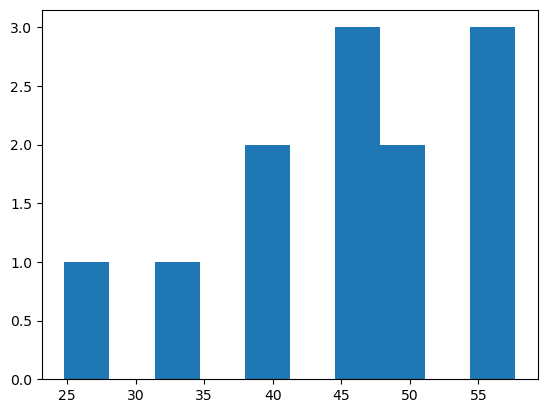

In [13]:
plt.hist(my_regions['mean_intensity']);

## Filtering information

Obviously, we had some "bad segmentations", i.e. some fragments remaining from the processing that are not actual nuclei. We can easily filter those out for example based on size using Numpy logical indexing:

In [14]:
my_regions['area']

array([ 9304., 14388.,    52., 20816., 28309., 16148., 21329., 34818.,
       32314., 34576., 22307., 24143.])

We create a logical array by setting a condition on one dictionary entry:

In [16]:
selected = my_regions['area'] > 100
selected

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

And then use it for logical indexing:

In [17]:
my_regions['mean_intensity'][selected]

array([24.8133061 , 39.03287462, 47.2842525 , 45.06778763, 40.15779044,
       50.52252801, 49.44723993, 57.68608034, 55.5311777 , 47.08172323,
       55.98339063])

## Other types of information

Beyond geometric and intensity information, regions props also allows us to recover image information. For example:

In [18]:
my_regions2 = skimage.measure.regionprops_table(
    my_labels,intensity_image=image_signal, properties=('label','area','image_intensity'))

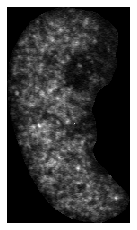

In [19]:
microshow(my_regions2['image_intensity'][10]);

Here via ```image-intensity``` we can recover just crops of the intensity image corresponding to each label. We could also recover the mask, convex boundaries etc.

## Exercise

Using the plant image ```IMG_6499.jpg```:
1. Keep only the green channel
2. Filter it with a gaussian with ```sigma = 20```
3. Create a masks by thresholding with the Li method
4. Transform the mask into a labels image
5. Compute properties of the labels, at least the area
6. Make a histogram of the area. What do you observe and does it make sense?